In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
# from livelossplot import PlotLossesTensorFlowKeras
import tensorflow as tf

2023-02-23 21:21:29.760288: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-23 21:21:29.760317: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
img_size = 48
batch_size = 64

# Data generator to augment data for training
datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory("FER2013/train/", 
                                                    target_size=(img_size,img_size), 
                                                    color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=True)

# Data generator to augment data for validation
datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_train.flow_from_directory("FER2013/test/", 
                                                    target_size=(img_size,img_size), 
                                                    color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [3]:
model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())


model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2023-02-23 21:21:33.870475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 21:21:33.870932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-23 21:21:33.871023: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-23 21:21:33.871076: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-23 21:21:33.887823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

/home/prat/.local/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
rlrp = ReduceLROnPlateau(monitor='val_loss' , factor=0.1, patience=2, min_lr=0.00001,model='auto')
checkpoint = ModelCheckpoint("videoModel.h5",monitor='val_accuracy', save_weights_only=True, mode='max',verbose=1)
history=model.fit(x=train_generator,steps_per_epoch=train_generator.n//train_generator.batch_size, epochs=10, callbacks=[rlrp], validation_data=validation_generator)

Epoch 1/10
448/448 [==============================] - 286s 639ms/step - loss: 1.4775 - accuracy: 0.4361 - val_loss: 1.3555 - val_accuracy: 0.4756 - lr: 5.0000e-04
Epoch 2/10
289/448 [==================>...........] - ETA: 1:35 - loss: 1.3507 - accuracy: 0.4830

KeyboardInterrupt: 

In [5]:
import numpy as np
from sklearn import metrics


In [8]:
import cv2
cap = cv2.VideoCapture(0)
cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'))
cap.set(cv2.CAP_PROP_FPS, 30)
font = cv2.FONT_HERSHEY_PLAIN
EMOTIONS_LIST = ["Angry", "Disgust", "Fear", "Happy", "Neutral","Sad","Surprised"]
while(True):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces_rect = cascade.detectMultiScale(
    gray, scaleFactor=1.1, minNeighbors=9)
    for (x, y, w, h) in faces_rect:
        fc = gray[y:y+h, x:x+w]
        roi = cv2.resize(fc, (48, 48))
        pred = model.predict(roi[np.newaxis, :, :, np.newaxis])
        cv2.putText(frame, EMOTIONS_LIST[np.argmax(pred)], (x+(w//3), y-5), font, 5, (0, 0, 255), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

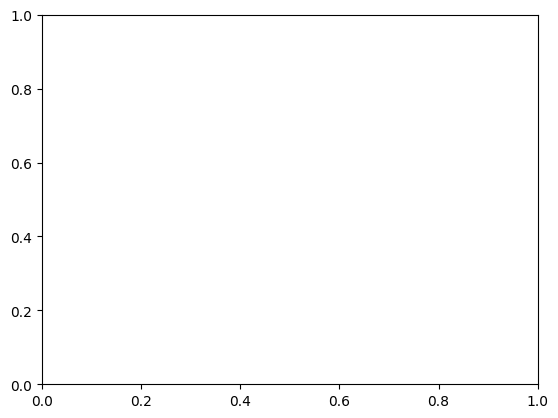

In [6]:
acc = history.history['accuracy']
epochs = range(0,10)
plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
plt.title('VSA Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()